## Within-host effects of NAIs

In [91]:
# Necessary packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
import seaborn as sns
from scipy.integrate import odeint
%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='Set2')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

### The system of equations

The within-host model of infection is given by:

$$\dot{T} = -\beta TV$$

$$\dot{J} = \beta TV - kJ$$

$$\dot{I} = kJ-\delta I$$

$$\dot{V} = p\left(1-\frac{D}{D+EC_{50}}\right)I-cV$$

$$\dot{\Psi} = \theta I - a \Psi$$

$$\dot{D} = \gamma D$$

where $T$ are susceptible target cells, $J$ infected cells, $I$ productively infected cells, $V$ the viral load, $\Psi$ the symptoms intensity and $D$ the drug concentration.

**Note:** see the paper in the `docs` directory for details.

### Analytical results

#### Visualising $D(t)$ and $\varepsilon(t)$

The cell below contains the expressions for the time-dependent efficacy of the drug and the lower and upper limits of the drug concentration, as well as the efficacy corresponding to the latter. These are:

$$\varepsilon(t) = \frac{D(t)}{D(t) + EC_{50}}$$

$$D_l = D_0\frac{e^{-\gamma \tau}}{1-e^{-\gamma \tau}}$$

$$D_u = D_0\frac{1}{1-e^{-\gamma \tau}}$$

$$\varepsilon^* = \varepsilon(D_u) = D_0 \frac{e^{\gamma \tau}}{(D_0 + EC_{50})e^{\gamma \tau} - EC_{50}}$$

In [12]:
def eps_drug(drug, EC50):
    return drug/(drug + EC50)

def dose_low(interval, dose, gamma):
    return dose*np.exp(-gamma*interval)/(1. - np.exp(-gamma*interval))

def dose_up(interval, dose, gamma):
    return dose/(1. - np.exp(-gamma*interval))

def efficacy(interval, dose, gamma, EC50):
    return np.exp(gamma*interval)*dose/(np.exp(gamma*interval)*dose + np.exp(gamma*interval)*EC50 - EC50)

v_eps_drug = np.vectorize(eps_drug)

Here we show an illustration of the convergence of the peaks and valleys of drug concentration and efficacy.

In [13]:
# Parameters

gamma = 3.26 # drug elimination rate [1/days]
tau = 0.5 # time interval between drug intakes [days]

dose = 75. # drug dose [mg]

dt = 1e-3 # sampling interval
t = np.arange(0., 5.5 + dt, dt) # integration time

intakes = np.arange(tau, 5.5 + tau, tau) # times of intake


# The constant values

peak_eps = efficacy(tau, dose, gamma, 15) # the peak efficacy for EC50=15mg (for visualisation only)
peak_dose = dose_up(tau, dose, gamma)/dose # peak drug concentration as a fraction of the dose
valley_dose = dose_low(tau, dose, gamma)/dose # valley of drug concentration as a fraction of the dose


# Time-varying drug concentration

drug_t = []
drug = 0.

for time in t:
    drug *= np.exp(-gamma*dt)
    
    if time in intakes:
        drug += dose
            
    drug_t.append(drug/dose)

**Note:** the scaling of the figures corresponds to the one in the paper. Here, and in all cases below, you are welcome to play around with the `figsize` and `fontsize` flags in order to produce larger plots.

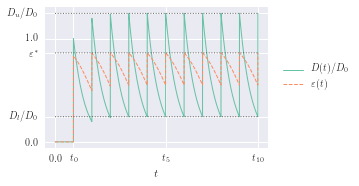

In [14]:
# Plot

fig, ax = plt.subplots(figsize=(4, 2.6)) # change for larger plot 
ax.plot(t, drug_t, linewidth=1., label=r'$D(t)/D_0$')
ax.plot(t, v_eps_drug(drug_t, 15./dose), linestyle='--', linewidth=1., label=r'$\varepsilon(t)$')
ax.plot(t, np.full_like(t, peak_eps), linestyle=':', linewidth=1., color='k', alpha=0.6)
ax.plot(t, np.full_like(t, valley_dose), linestyle=':', linewidth=1., color='k', alpha=0.6)
ax.plot(t, np.full_like(t, peak_dose), linestyle=':', linewidth=1., color='k', alpha=0.6)

ax.set_xticks([0., tau, 6*tau, 11*tau])
ax.set_xticklabels([0., r'$t_0$', r'$t_5$', r'$t_{10}$'], fontsize=10)
ax.set_yticks([0., valley_dose, peak_eps, 1., peak_dose])
ax.set_yticklabels([0., r'$D_l/D_0$', r'$\varepsilon^*$', 1., r'$D_u/D_0$'], fontsize=10)

ax.set_xlabel(r'$t$', fontsize=12)
ax.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), fontsize=10)


# Uncomment the line below to overwrite the output

# plt.savefig('../figures/D_eps.pdf', bbox_inches='tight')

#### Peak efficacy as a function of treatment, for different half-maximal concentrations of the NAI

In this case we fix values for $EC_{50}$ (ie., we fix the drug) and show contours of constant peak efficacy, $\varepsilon^*$, as a function of the treatment dose and time interval between intakes.

In [15]:
EC50 = [0.01, 5, 500] # the different values of EC50 to evaluate [mg]

interval = np.linspace(0, 1, 500) # the range of intake intervals
doses = [np.linspace(0.01, 0.1, 100), np.linspace(5, 50, 500), np.linspace(500, 1000, 1000)] # the range of drug doses to visualise for each EC50

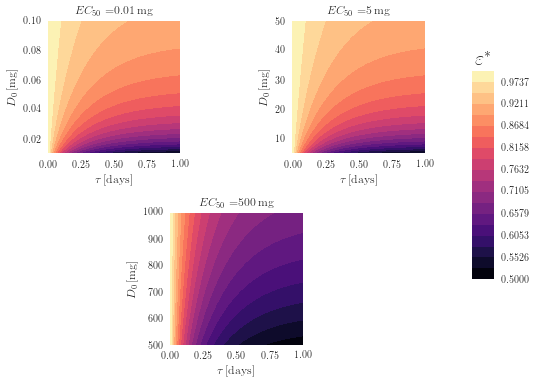

In [16]:
# Plot

fig, axes = plt.subplots()
axes = [plt.subplot2grid((4,4),(0,0),colspan=2, rowspan=2), plt.subplot2grid((4,4),(0,2),colspan=2, rowspan=2), plt.subplot2grid((4,4),(2,1),colspan=2, rowspan=2)]

for i in range(len(axes)):
    X, Y = np.meshgrid(interval, doses[i])
    Z = efficacy(X, Y, gamma, EC50[i])
    im = axes[i].contourf(X, Y, Z, cmap='magma', levels=np.linspace(0.5, 1.0, 20))
    axes[i].set_aspect((interval[-1]-interval[0])/(doses[i][-1]-doses[i][0]))
    axes[i].set_xlabel(r'$\tau\,\rm{[days]}$', fontsize=12)
    axes[i].set_ylabel(r'$D_0\,\rm{[mg]}$', fontsize=12)
    axes[i].set_title(r'$EC_{50}=$'+str(EC50[i])+r'$\!$ mg', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
fig.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.85, 0.28, 0.0375, 0.525])
fig.colorbar(im, cax=cbar_ax).ax.set_title(r'$\varepsilon^*$', fontsize=20)


# Uncomment the line below to overwrite the output

# plt.savefig('../figures/efficacy_treatment.pdf', bbox_inches='tight')

#### Peak efficacy as a function of NAI parameters, for different treatment regimens

In this case we fix the treatment regimen and show contours of constant peak efficacy, $\varepsilon^*$, as a function of the drug mean life and half-maximal concentration.

In [17]:
regimen_dose = [75, 150] # the treatment regimes to evaluate [mg]

halfmax = np.linspace(0., 500., 2000) # the range of EC50 to visualise
mean_life = np.linspace(0.001, 1.5, 300) # the range of mean lives (1/[elimination rate]) to visualise

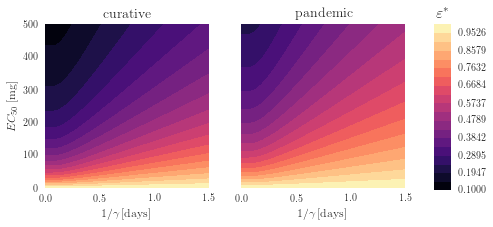

In [18]:
# Plot

fig, axes = plt.subplots()
axes = [plt.subplot2grid((1,2),(0,0)), plt.subplot2grid((1,2),(0,1))]

X, Y = np.meshgrid(mean_life, halfmax)
aspect = (mean_life[-1]-mean_life[0])/(halfmax[-1]-halfmax[0])
regimens = ['curative', 'pandemic']

for i in range(len(axes)):
    Z = efficacy(tau, regimen_dose[i], 1/X, Y)
    im = axes[i].contourf(X, Y, Z, cmap='magma', levels=np.linspace(0.1, 1.0, 20))
    axes[i].set_aspect(aspect)
    axes[i].set_xlabel(r'$1/\gamma\,\rm{[days]}$', fontsize=12)
    axes[i].set_title(regimens[i], fontsize=14)

axes[0].set_ylabel(r'$EC_{50}\,\rm{[mg]}$', fontsize=12)
axes[1].set_yticks([])

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
fig.subplots_adjust(right=0.75)
cbar_ax = fig.add_axes([0.8, 0.29, 0.03, 0.42])
fig.colorbar(im, cax=cbar_ax).ax.set_title(r'$\varepsilon^*$', fontsize=16)


# Uncomment the line below to overwrite the output

# plt.savefig('../figures/efficacy_drug.pdf', bbox_inches='tight')

### Simulations

Here, we simulate the within-host system and record the reduction in AUC for the viral load and symptoms. Simulations for which $V<V_{\rm min}$ (an arbitrary cuttoff that we set below) at 24h post infection are assumed to stop growing. In other words, in this case $ \dot{V} = - cV$ from $t=1$ day onwards. 

#### Eqs. and parameters

In [21]:
beta = 0.0674 # infection rate
k = 3.684 # 1/[mean time spent latently infected]
delta = 1.364 # 1/[mean time spent productively infected]
p = 40356. # virus shedding rate
c = 8. # virus clearance rate
theta = 2.75 # symptoms growth rate
a = 0.498 # symptoms clearance rate
V0 = 7.5e-6 # inoculum size
Vmin = 1e-3 # the cutoff for the viral load

x0 = [1., 0., 0., V0, 0.] # initial condition

def within_host(x, t, t0, epsilon):
    '''The solution to the within-host system'''
    
    T, J, I, V, Psi = x
    
    if t >= t0:
        p_eff = p*(1.0 - epsilon)
    else:
        p_eff = p
        
    dxdt = [-beta*T*V, beta*T*V - k*J, k*J - delta*I, p_eff*I - c*V, theta*I - a*Psi]
        
    return dxdt

def within_host_stop(x, t):
    '''The solution to the within-host system with no growth in the viral load'''
    
    T, J, I, V, Psi = x
        
    dxdt = [-beta*T*V, beta*T*V - k*J, k*J - delta*I, -c*V, theta*I - a*Psi]
        
    return dxdt

#### Within-host dynamics for different efficacies and different starting times

The reduction in AUC is recorded as a function of the starting time of the treatment and the peak efficacy of the drug.

The time-dependent behaviour of the variables is saved in `solution_list` for a selection of starting times and efficacies determined by `times_save` and `efficacies_save`, respectively. You are welcome to explore the case of other starting times.

**Note:** `odeint` does not have an event handler, so this is coded explicitly. The solution considers growth in $V$ until $t=1$, and then either continues or switches to the solution without growth depending on the last value of $V$ and its comparison to $V_{\rm min}$

In [33]:
times_init = np.arange(0., 4.05, 0.05) # range of therapy starting times
times_save = [0., 1., 2., 3.] # snapshots of therapy starting times

efficacies = np.arange(0.65, 1., 0.01) #range of peak efficacies
efficacies_save = [0.95] # snapshots of efficacy

dt = 0.00001 # integration interval
t = np.arange(0., 10. + dt, dt) # integration time
idx_day1 = np.argwhere(t == 1.)[0,0] # index of the time array for which t=1 day


# Solution and AUC without treatment

no_treatment = odeint(within_host, x0, t, args=(0., 0.))

V_0 = no_treatment[:, 3]
Psi_0 = no_treatment[:, 4]

AUC_v_0 = np.trapz(V_0, t)
AUC_psi_0 = np.trapz(Psi_0, t)


# The sweep for the case with treatment

solution_list = []

AUC_v = []
AUC_psi = []

for t0 in times_init:
    for epsilon in efficacies:
           
        solution = odeint(within_host, x0, t[: idx_day1 + 1], args=(t0, epsilon))
        
        x1 = solution[idx_day1]
        if x1[3] < Vmin:
            solution1 = odeint(within_host_stop, x1, t[idx_day1 :])
        else:
            solution1 = odeint(within_host, x1, t[idx_day1 :], args=(t0, epsilon))
            
            
        solution = np.concatenate((solution[: -1], solution1), axis=0)    
        V = solution[:, 3]    
        V = np.maximum(V, np.zeros_like(V))
        Psi = solution[:, 4]
        Psi = np.maximum(Psi, np.zeros_like(Psi))
        
        AUC_v.append([t0, epsilon, 1.0 - np.trapz(V, t)/AUC_v_0])
        AUC_psi.append([t0, epsilon, 1.0 - np.trapz(Psi, t)/AUC_psi_0])
        
        if np.ceil(t0*100)/100. in times_save and np.ceil(epsilon*100)/100. in efficacies_save:
            solution_list.append(solution)
        
AUC_v = np.array(AUC_v)
AUC_psi = np.array(AUC_psi)

#### AUC plots

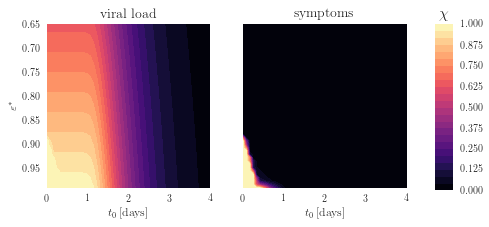

In [34]:
X, Y, Z = AUC_v[:, 0], AUC_v[:, 1], [AUC_v[:, 2], AUC_psi[:, 2]]

times = np.linspace(min(X), max(X))
effs = np.linspace(min(Y), max(Y))

fig, axes = plt.subplots()
axes = [plt.subplot2grid((1,2),(0,0)), plt.subplot2grid((1,2),(0,1))]

aspect = (times[-1]-times[0])/(effs[-1]-effs[0])
variables = ['viral load', 'symptoms'] 

for i in range(len(axes)):
    AUCs = griddata(X, Y, np.maximum(Z[i], np.zeros_like(Z[i])), times, effs, interp='linear')
    im = axes[i].contourf(times, effs, AUCs, cmap='magma', levels=np.linspace(0., 1., 25))
    axes[i].set_aspect(aspect)
    axes[i].set_xlabel(r'$t_0\,\rm{[days]}$', fontsize=12)
    axes[i].set_title(variables[i], fontsize=14)
    axes[i].invert_yaxis()

axes[0].set_ylabel(r'$\varepsilon^*$', fontsize=12)
axes[1].set_yticks([])

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
fig.subplots_adjust(right=0.75)
cbar_ax = fig.add_axes([0.8, 0.29, 0.03, 0.42])
fig.colorbar(im, cax=cbar_ax).ax.set_title(r'$\chi$', fontsize=16)


# Uncomment the line below to overwrite the output

#plt.savefig('../figures/AUCs.pdf', bbox_inches='tight')

#### Plots for $V(t)$ and $\Psi(t)$

Each element of `solution_list` corresponds to one of the combinations of parameters saved. The solution has elements of the form:

`[T, J, I, V, Psi]`

for each time step, where the index starts from 0.


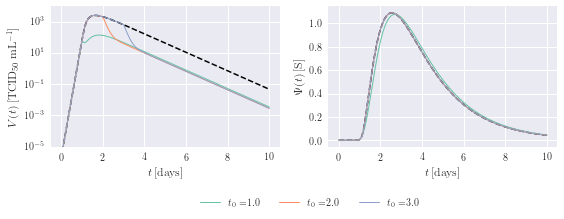

In [37]:
V = [solution_list[i][:, 3] for i in range(len(solution_list))]
Psi = [solution_list[i][:, 4] for i in range(len(solution_list))]
X_0 = [V_0, Psi_0]
X = [V, Psi]
var = [r'$V(t)\,\rm{[TCID_{50}\, mL^{-1}]}$', r'$\Psi(t)\,\rm{[S]}$']

fig, axes = plt.subplots(1,2, figsize=(8,2.75))  # change for larger plot

axes[0].set_yscale('log')
axes[0].set_ylim(1e-5,1e4)
for i in range(len(axes)):
    axes[i].plot(t, X_0[i], linestyle='--', color='k', linewidth=1.5)
    axes[i].set_xlabel(r'$t\,\rm{[days]}$', fontsize=12)
    axes[i].set_ylabel(var[i], fontsize=12)
    for j in range(1, len(solution_list)): # we omit t0=0 for this plot
        axes[i].plot(t, X[i][j], linewidth=1., label=r'$t_0=$'+str(times_save[j]))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
        
axes[1].legend(loc='lower left', bbox_to_anchor=(-0.6, -0.5), ncol=3, fontsize=10)


# Uncomment the line below to overwrite the output

# plt.savefig('../figures/V_Psi.pdf', bbox_inches='tight')

#### Phase diagrams

We show only one combination. You are welcome to play around with the rest.

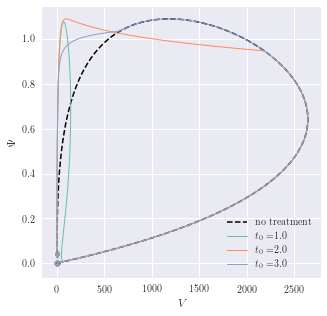

In [103]:
# V and Psi have already been obtained from solution_list above
## For a different combination of variables uncomment the lines below and change X_0, Y_0, X and Y accordingly
### Remember to change the labels of the plot

# T_0 = no_treatment[:, 0]
# J_0 = no_treatment[:, 1]
# I_0 = no_treatment[:, 2]
# V_0 = no_treatment[:, 3]
# Psi_0 = no_treatment[:, 4]

# T = [solution_list[i][:, 0] for i in range(len(solution_list))]
# J = [solution_list[i][:, 1] for i in range(len(solution_list))]
# I = [solution_list[i][:, 2] for i in range(len(solution_list))]
# V = [solution_list[i][:, 3] for i in range(len(solution_list))]
# Psi = [solution_list[i][:, 4] for i in range(len(solution_list))]

X_0 = V_0
Y_0 = Psi_0

X = V
Y = Psi

fig, ax = plt.subplots(figsize=(5,5)) # change for larger plot

ax.plot(X_0, Y_0, label='no treatment', c='k', linestyle='--', linewidth=1.5)
ax.scatter(X_0[:1], Y_0[:1], marker='o', c='k', s=30) # initial point marked with a circle
ax.scatter(X_0[-1:], Y_0[-1:], marker='d', c='k', s=30) # final point marked with a diamond

for i in range(1, len(solution_list)): # we omit t0=0 for this plot
    ax.plot(X[i], Y[i], linewidth=1., label=r'$t_0=$'+str(times_save[i]))
    ax.scatter(X[i][:1], Y[i][:1], marker='o', c=colours[i-1], s=30) # initial point marked with a circle
    ax.scatter(X[i][-1:], Y[i][-1:], marker='d', c=colours[i-1], s=30) # final point marked with a diamond
    
ax.set_xlabel(r'$V$', fontsize=12) # change labels here
ax.set_ylabel(r'$\Psi$', fontsize=12) # change labels here
ax.legend()


# Uncomment the line below (and change the file name according to the variables) to overwrite the output

# plt.savefig('../figures/phase_V_Psi.pdf', bbox_inches='tight')